In [ ]:
import networkx as nx
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
import time

In [ ]:
plt_options = {
  "node_size": 350,
  "node_color": "white",
  "edgecolors": "black",
  "with_labels": True,
  "font_size": 8
}

agent_path_draw_delay = 1

In [ ]:
def setup_road(n_edges_to_remove, m = 5, n = 5):
  G = nx.grid_2d_graph(m, n)

  available_edges = list(G.edges)

  max_edges_to_remove = len(list(G.edges)) - len(list(G.nodes)) + 1

  i = 0

  while i < n_edges_to_remove and i < max_edges_to_remove:
    selected_edge = random.choice(available_edges)
    G.remove_edge(*selected_edge)

    if not nx.is_connected(G):
      G.add_edge(*selected_edge)
    else:
      i += 1

    available_edges.remove(selected_edge)

  return G

In [ ]:
def draw_agent_path(path, road, current_crossroads, visited_crossroads):
    edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    edge_labels = {edge: i + 1 for i, edge in enumerate(edges)}

    pos = {(x,y):(y,-x) for x,y in road.nodes()}

    path_node_color = ['red' if node == current_crossroads else 'yellowgreen' for node in path]
    visited_crossroads_node_color = ['gray' if node in visited_crossroads else 'white' for node in road.nodes]

    plt.figure(figsize=(5,5))
    nx.draw(road, pos=pos, **{ **plt_options, 'node_color': visited_crossroads_node_color })
    nx.draw_networkx_nodes(road, nodelist=path, pos=pos, node_color=path_node_color)
    nx.draw_networkx_edges(road, edgelist=edges, pos=pos, edge_color='yellowgreen')
    nx.draw_networkx_edge_labels(road, edge_labels=edge_labels, pos=pos)
    plt.show()

In [ ]:
class Agent:
  def __init__(self, road):
    self.road = road

  def drive(self, dep, dest):
    visited_crossroads = []

    stack = []

    stack.append(dep)

    current_crossroads = dep

    moves_count = 0

    while len(stack):
      moves_count += 1

      visited_crossroads.append(current_crossroads)

      if current_crossroads == dest:
        print(f"🟢 Stop! Path is found: {stack}")

        draw_agent_path(stack, self.road, current_crossroads, visited_crossroads)

        return stack

      neighbors = self.road.neighbors(current_crossroads)
      unvisited_neighbors = []

      for neighbor in neighbors:
        if neighbor not in visited_crossroads:
          unvisited_neighbors.append(neighbor)

      if not len(unvisited_neighbors):
        stack.pop()

        if not len(stack):
          print("❌ Path wasn't found!")

          return []

        current_crossroads = stack[-1]

        print(f"#{moves_count} 🔴 Dead end! Move back to {stack[-1]}")
      else:
        next_crossroads = random.choice(unvisited_neighbors)
        stack.append(next_crossroads)
        current_crossroads = next_crossroads

        print(f"#{moves_count} Move: {next_crossroads}")

      draw_agent_path(stack, self.road, current_crossroads, visited_crossroads)

      time.sleep(agent_path_draw_delay)
      clear_output(wait=True)

🟢 Stop! Path is found: [(2, 2), (2, 1), (2, 0), (3, 0), (4, 0), (4, 1), (3, 1), (3, 2), (3, 3), (4, 3), (4, 4)]


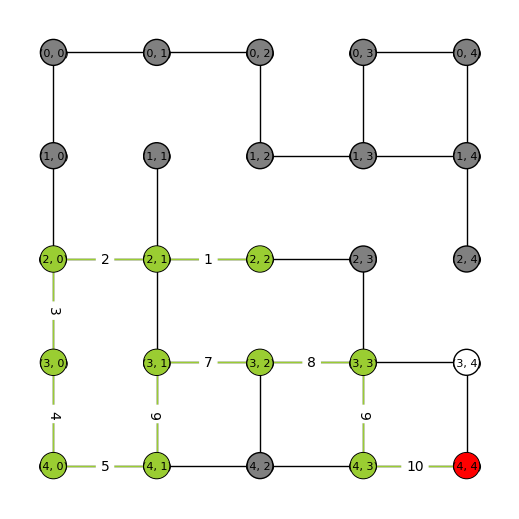

[(2, 2),
 (2, 1),
 (2, 0),
 (3, 0),
 (4, 0),
 (4, 1),
 (3, 1),
 (3, 2),
 (3, 3),
 (4, 3),
 (4, 4)]

In [ ]:
road = setup_road(n_edges_to_remove=10)
agent = Agent(road)

agent.drive((2, 2), (4, 4))

**Висновок**: виконавши дану лабораторну роботу, було отримано навички роботи з інтелектуальними агентами. Розроблено раціонального інтелектуального агента, що враховує мету - доїхати з початкової точки в точку призначення по граф-дорозі, розробленій в попередній лабораторній роботі. Також було реалізовано механізм відображення стану шляху агента після кожного пересування по дорозі.